In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)


In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format

df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Italy,US,Spain,Germany,"Korea, South"
0,2020-01-22,0,1,0,0,1
1,2020-01-23,0,1,0,0,1
2,2020-01-24,0,2,0,0,2
3,2020-01-25,0,2,0,0,2
4,2020-01-26,0,5,0,0,3


In [3]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate


# condition I0+S0+R0=N0
I0=df_analyse.Germany[35]
S0=N0-I0
R0=0

In [4]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

# Simulative approach to calculate SIR curves

In [5]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


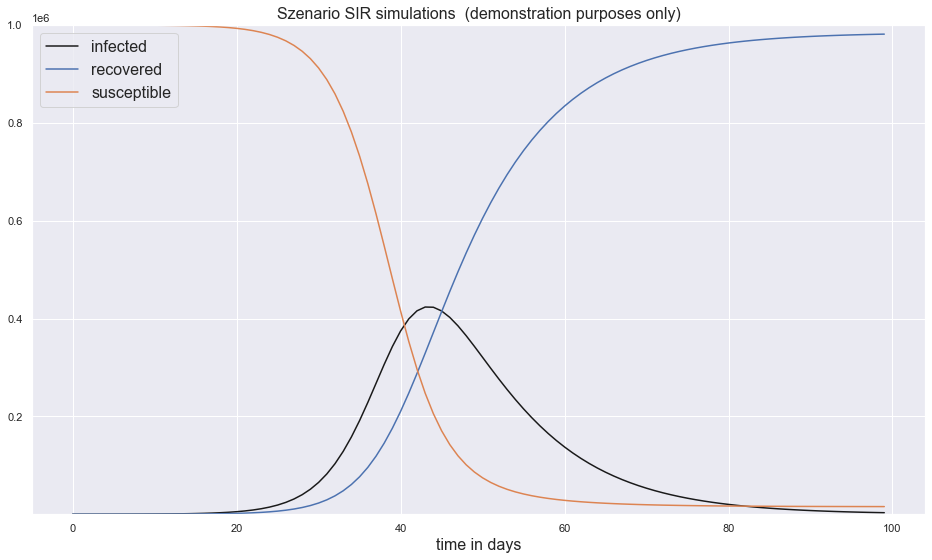

In [6]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting the parameters of SIR model

In [7]:
ydata = np.array(df_analyse.Germany[35:])
t=np.arange(len(ydata))

In [8]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [9]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [10]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [11]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([ 2.10000000e+01,  2.83467442e+01,  3.82635349e+01,  5.16492851e+01,
        6.97171980e+01,  9.41045567e+01,  1.27020786e+02,  1.71447062e+02,
        2.31405299e+02,  3.12320402e+02,  4.21507742e+02,  5.68828389e+02,
        7.67568562e+02,  1.03561758e+03,  1.39704132e+03,  1.88417601e+03,
        2.54040014e+03,  3.42377774e+03,  4.61179988e+03,  6.20746901e+03,
        8.34695108e+03,  1.12089170e+04,  1.50254352e+04,  2.00937383e+04,
        2.67872046e+04,  3.55622587e+04,  4.69554712e+04,  6.15620761e+04,
        7.99843269e+04,  1.02737867e+05,  1.30110563e+05,  1.61985487e+05,
        1.97668411e+05,  2.35790176e+05,  2.74361695e+05,  3.11019967e+05,
        3.43420416e+05,  3.69650711e+05,  3.88523547e+05,  3.99666850e+05,
        4.03424001e+05,  4.00642226e+05,  3.92438005e+05,  3.80000472e+05,
        3.64456984e+05,  3.46798540e+05,  3.27850544e+05,  3.08272539e+05,
        2.88573617e+05,  2.69134372e+05,  2.50230013e+05,  2.32051744e+05,
        2.14725295e+05,  

In [12]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

In [13]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

c:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [63.85971708 63.35595702]  start infect: 21
Optimal parameters: beta = 1.0990472840791212  and gamma =  0.899025500927346


C:\Users\DELL\AppData\Local\Temp\ipykernel_2024\649699423.py:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
C:\Users\DELL\AppData\Local\Temp\ipykernel_2024\649699423.py:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\DELL\AppData\Local\Temp\ipykernel_2024\649699423.py:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I
c:\ProgramData\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [14]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

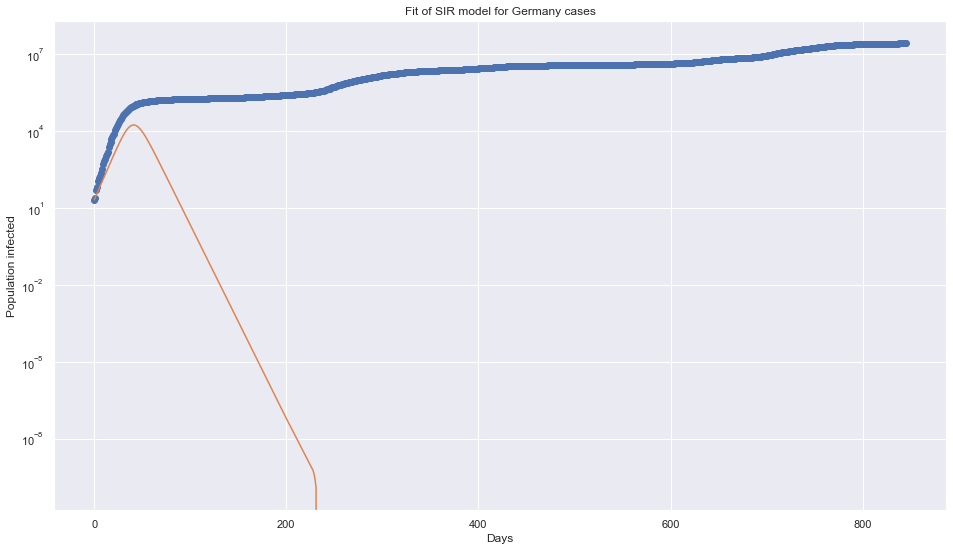

Optimal parameters: beta = 1.0990472840791212  and gamma =  0.899025500927346
Basic Reproduction Number R0  1.222487329831526
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [15]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic beta in SIR (infection rate)

In [16]:
t_initial=28
t_intro_measures=14
t_hold=21
t_relax=21

beta_max=0.4
beta_min=0.11
gamma=0.1
pd_beta=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

In [17]:
pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.37769231,
       0.35538462, 0.33307692, 0.31076923, 0.28846154, 0.26615385,
       0.24384615, 0.22153846, 0.19923077, 0.17692308, 0.15461538,
       0.13230769, 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.1245    ,
       0.139     , 0.1535    , 0.168     , 0.1825    , 0.197     ,
       0.2115    , 0.226     , 0.2405    , 0.255     , 0.2695 

In [18]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_beta in pd_beta:
   
    new_delta_vec=SIR_model(SIR,each_beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)

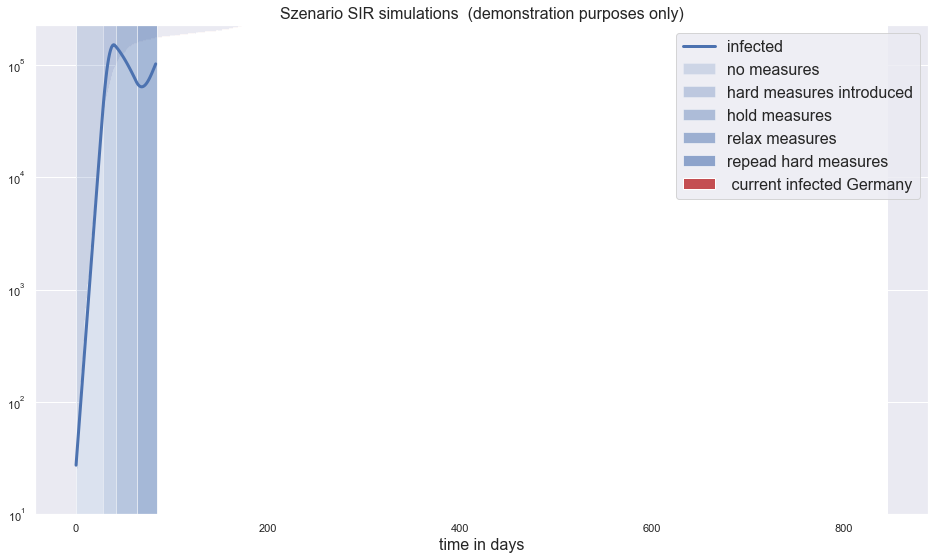

In [19]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

t_phases=np.array([t_initial,t_intro_measures,t_hold,t_relax]).cumsum()
ax1.bar(np.arange(len(ydata)),ydata, width=0.8,label=' current infected Germany',color='r')
ax1.axvspan(0,t_phases[0], facecolor='b', alpha=0.2,label='no measures')
ax1.axvspan(t_phases[0],t_phases[1], facecolor='b', alpha=0.3,label='hard measures introduced')
ax1.axvspan(t_phases[1],t_phases[2], facecolor='b', alpha=0.4,label='hold measures')
ax1.axvspan(t_phases[2],t_phases[3], facecolor='b', alpha=0.5,label='relax measures')
ax1.axvspan(t_phases[3],len(propagation_rates.infected), facecolor='b', alpha=0.6,label='repead hard measures')

ax1.set_ylim(10, 1.5*max(propagation_rates.infected))
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});